### Sentiment Analysis for Yelp Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [2]:
# LOADING THE DATASET AND SEEING THE DETAILS
data = pd.read_csv('yelp.csv')

# SHAPE OF THE DATASET
print("Shape of the dataset:")
data.shape

Shape of the dataset:


(10000, 10)

In [3]:
# Features of the dataset
data.dtypes

business_id    object
date           object
review_id      object
stars           int64
text           object
type           object
user_id        object
cool            int64
useful          int64
funny           int64
dtype: object

In [4]:
# SEEING FEW OF THE ENTRIES
data.head(5)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
#Removing the unwanted columns from the dataset
data.drop(['business_id','date','review_id','type','user_id'], axis = 1, inplace = True)
data.head()

,stars,text,cool,useful,funny
0,5,My wife took me here on my birthday for breakf...,2,5,0
1,5,I have no idea why some people give bad review...,0,0,0
2,4,love the gyro plate. Rice is so good and I als...,0,1,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0


In [6]:
# Adding Text length feature for each comment.
data['length'] = data['text'].apply(len)
data.head()

,stars,text,cool,useful,funny,length
0,5,My wife took me here on my birthday for breakf...,2,5,0,889
1,5,I have no idea why some people give bad review...,0,0,0,1345
2,4,love the gyro plate. Rice is so good and I als...,0,1,0,76
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,419
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0,469


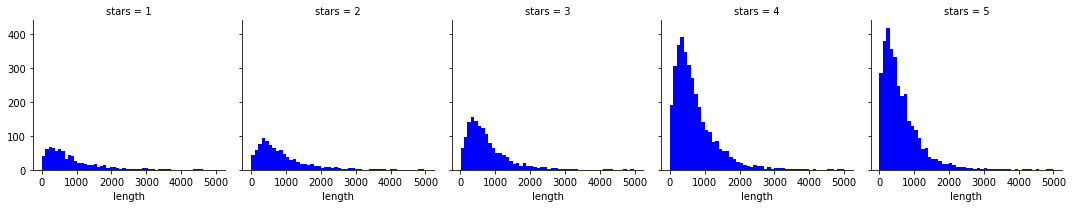

In [7]:
#Comparing between stars and text length.
graph = sns.FacetGrid(data=data,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

In [8]:
# FINDING THE CORRELATION BETWEEN THE VOTE COLUMNS
stval = data.groupby('stars').mean()
stval.corr()

,cool,useful,funny,length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
length,-0.857664,0.699881,0.843461,1.000000


###### Thus, we can see that there is negative correlation between:
* Cool and Useful
* Cool and Funny
* Cool and Length 

#### Talking about positively correlated votes

* Funny and Useful    
* Funny and Length
* Useful and Length 

#### Thus longer reviews tend to be useful and funny by the viewers

##### Lets now clean the Text by removing stop words and punctuations

In [9]:
# CLEANING THE REVIEWS - REMOVAL OF STOPWORDS AND PUNCTUATION AND NUMBERS
import re
def text_process(text):
    text = re.sub(r'[0-9]+', '', text)
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


In [10]:
data['ones'] = 1
data['score'] = data['ones'].where(data['stars']> 3)
data['score'].fillna(0, inplace=True)
data.tail()

,stars,text,cool,useful,funny,length,ones,score
9995,3,First visit...Had lunch here today - used my G...,1,2,0,668,1,0.0
9996,4,Should be called house of deliciousness!\n\nI ...,0,0,0,881,1,1.0
9997,4,I recently visited Olive and Ivy for business ...,0,0,0,1425,1,1.0
9998,2,My nephew just moved to Scottsdale recently so...,0,0,0,880,1,0.0
9999,5,4-5 locations.. all 4.5 star average.. I think...,0,0,0,461,1,1.0


In [12]:
# Assigning dependent and independent variables for classification
x = data['text']
y = data['score']
print(y.head())
print(x.head())

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: score, dtype: float64
0    My wife took me here on my birthday for breakf...
1    I have no idea why some people give bad review...
2    love the gyro plate. Rice is so good and I als...
3    Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4    General Manager Scott Petello is a good egg!!!...
Name: text, dtype: object


In [13]:
#Applying text_process function and vector transform for a single comment.
vocab = CountVectorizer(analyzer=text_process).fit(x)
print(len(vocab.vocabulary_))
r0 = x[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0)

42733
My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!
  (0, 528)	1
  (0, 1383)	1
  (0, 3858)	1
  (0, 6033)	1
  (0, 6210)	2
  (0, 7660)	1
  (0, 10880)	1
  (0, 

In [14]:
print(vocab.get_feature_names()[33811])

quickly


In [15]:
#Transform documents to document-term matrix.
x = vocab.transform(x)

In [16]:
#split the train and test data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1)
x_test

<2000x42733 sparse matrix of type '<class 'numpy.int64'>'
	with 112801 stored elements in Compressed Sparse Row format>

### Classification Models

In [17]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmnb))


Confusion Matrix for Multinomial Naive Bayes:
[[ 373  248]
 [ 127 1252]]
Score: 81.25
Classification Report:
             precision    recall  f1-score   support

        0.0       0.75      0.60      0.67       621
        1.0       0.83      0.91      0.87      1379

avg / total       0.81      0.81      0.81      2000



In [18]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:")
print(classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[ 317  304]
 [ 153 1226]]
Score: 77.15
Classification Report:
             precision    recall  f1-score   support

        0.0       0.67      0.51      0.58       621
        1.0       0.80      0.89      0.84      1379

avg / total       0.76      0.77      0.76      2000



In [18]:
# Support Vector Machine
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(x_train,y_train)
predsvm = svm.predict(x_test)
print(predsvm)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:")
print(classification_report(y_test,predsvm))

[1. 1. 1. ... 1. 1. 1.]
Confusion Matrix for Support Vector Machines:
[[   0  621]
 [   0 1379]]
Score: 68.95
Classification Report:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00       621
        1.0       0.69      1.00      0.82      1379

avg / total       0.48      0.69      0.56      2000



In [20]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)

print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 407  214]
 [ 176 1203]]
Score: 80.5
Classification Report:
             precision    recall  f1-score   support

        0.0       0.70      0.66      0.68       621
        1.0       0.85      0.87      0.86      1379

avg / total       0.80      0.81      0.80      2000



In [23]:
#proof of predicting positive review
pr = data['text'][0]
print(pr)
print("Actual Rating: ",data['stars'][0])
pr_t = vocab.transform([pr])
print("Predicted score:")
mnb.predict(pr_t)[0]

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!
Actual Rating:  5
Predicted score:


1.0

In [24]:
#proof of predicting negative review
nr = data['text'][16]
print(nr)
print("Actual Rating: ",data['stars'][23])
nr_t = vocab.transform([nr])
print("Predicted score:")
mnb.predict(nr_t)[0]

We went here on a Saturday afternoon and this place was incredibly empty.  They had brunch specials going on, including $2 bloody mary's and mimosas, but we were more in the mood for lunch.  Except for the bloody mary, I had to try one.  It came out in a high-ball-sized glass.  Boo!  But it was really tasty. Yay!  The hubby remembered a sign outside the restaurant a few weeks back that said they had Arrogant Bastard, and he got a 22 oz bottle for $4.75.  Hey, that's not fair!!

Next up: the wings.  We were a bit hesitant to order them when the waitress informed us that they are "seasoned" but not sauced, so they can't be ordered hot.  We did ask for them crispy though, and the waitress even asked the cooks to throw them back in for a few minutes when they came out not visibly crispy.  These non-traditional wings were actually pretty damn good.  The seasoning was a little spicy and salty with just a hint of sweet.  If I were in the mood for the tang and kick of Frank's Hot Sauce, these 

0.0

### Conclusion

The above built model is only based on training yelp dataset. These models cannot be used to predict the score or polarity of any irrelavent data like movie_reviews etc. which leads to inaccurate prediction with less accuracy.

### Referance

Dataset: https://www.kaggle.com/omkarsabnis/yelp-reviews-dataset